<a href="https://colab.research.google.com/github/morankim/DCGAN-on-CelebA/blob/main/DCGAN_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:

import time
import os
import numpy as np
import torch
import random
import h5py, pandas

import torch.nn.functional as F
import torch.nn as nn
import torchvision.utils as vutils

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002
NUM_EPOCHS = 50
BATCH_SIZE = 128
NUM_WORKERS = 0 # workers for data loader

IMAGE_SIZE = (64, 64, 3)

# Size of the latent vector
LATENT_DIM = 100

# Number of feature maps in generator and discriminator
NUM_MAPS_GEN = 64
NUM_MAPS_DIS = 64

In [ ]:

# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [ ]:
def generate_random_image(size):
    random_data = torch.rand(size, device = device)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(1, size, 1, 1, device = device)
    return random_data

class View(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape,
  
  def forward(self, x):
    return x.view(*self.shape)

def crop_center(img, new_width, new_height):
  tf = transforms.RandomResizedCrop(new_width, scale=(0.96, 1.0), ratio=(0.95, 1.05))
  img = tf(img)
  img = np.array(img)
  return img[new_height, new_width, :]

In [ ]:
class CelebADataset(Dataset):
  
  def __init__(self, file, transform=None):
    self.file_object = h5py.File(file, 'r')
    self.dataset = self.file_object['img_align_celeba_20000']
    self.transform = transform
    pass

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    if(index>= len(self.dataset)):
      raise IndexError()
    img = np.array(self.dataset[str(index)+'.jpg'])
    img = Image.fromarray(img) # convert to PIL image
    img = np.array(self.transform(img).permute(1, 2, 0) )
    return torch.cuda.FloatTensor(img).permute(2,0,1).view(1, 3, IMAGE_SIZE[0],IMAGE_SIZE[1])
    #return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,IMAGE_SIZE[0],IMAGE_SIZE[1]) / 255.0

  def plot_image(self, index):
    img = np.array(self.dataset[str(index)+'.jpg'])

    img = Image.fromarray(img) # convert to PIL image
    img = self.transform(img).permute(1, 2, 0) # input PIL image -> Tensor-> index re-odering
    plt.imshow(img, interpolation='nearest')
    pass
  pass

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomRotation(5),
        #transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(IMAGE_SIZE[0], scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        # normalize images to [-1, 1] range
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

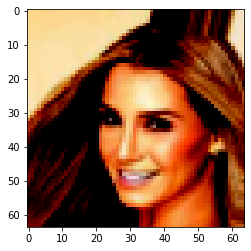

In [ ]:
celeba_dataset = CelebADataset('mount/My Drive/Colab Notebooks/myo_gan/celeba/celeba_aligned_small.h5py', transform = data_transforms['train'])

# check data contains images
celeba_dataset.plot_image(0)

In [ ]:
# Some model code is loosely inspired by 
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

def weights_init(module):
    """
    Function that initializes weights according to
    Radford et al.'s DCGAN paper
    """
    classname = module.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

In [ ]:
# discriminator class

class DCGAN(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super(DCGAN, self).__init__()
        
        # define neural network layers
        self.discriminator = nn.Sequential(
            nn.Conv2d(IMAGE_SIZE[2], NUM_MAPS_DIS,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS x 32 x 32
            #              
            nn.Conv2d(NUM_MAPS_DIS, NUM_MAPS_DIS*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(NUM_MAPS_DIS*2),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS*2 x 16 x 16
            #   
            nn.Conv2d(NUM_MAPS_DIS*2, NUM_MAPS_DIS*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(NUM_MAPS_DIS*4),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS*4 x 8 x 8
            #   
            nn.Conv2d(NUM_MAPS_DIS*4, NUM_MAPS_DIS*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(NUM_MAPS_DIS*8),
            nn.LeakyReLU(0.2, inplace=True),
            #
            # size: NUM_MAPS_DIS*8 x 4 x 4
            #   
            nn.Conv2d(NUM_MAPS_DIS*8, 1,
                      kernel_size=4, stride=1, padding=0),
            
            #View(1*1*1),
            #nn.Linear(1*1*1, 1),
            nn.Sigmoid()
        )

        self.generator = nn.Sequential(
          # input is a 1d array
          #nn.Linear(100, 100*1*1),
          #nn.LeakyReLU(0.2),
          
          # reshape to 4d
          #View((1, 100, 1, 1)),

          nn.ConvTranspose2d(LATENT_DIM, NUM_MAPS_GEN*8, 
                            kernel_size=4, stride=1, padding=0,
                            bias=False), # bias is redundant when using BatchNorm
          nn.BatchNorm2d(NUM_MAPS_GEN*8),
          nn.ReLU(True),
          #
          # size: NUM_MAPS_GEN*8 x 4 x 4
          #
          nn.ConvTranspose2d(NUM_MAPS_GEN*8, NUM_MAPS_GEN*4, 
                            kernel_size=4, stride=2, padding=1,
                            bias=False),
          nn.BatchNorm2d(NUM_MAPS_GEN*4),
          nn.ReLU(True),
          #
          # size: NUM_MAPS_GEN*4 x 8 x 8
          #
          nn.ConvTranspose2d(NUM_MAPS_GEN*4, NUM_MAPS_GEN*2, 
                            kernel_size=4, stride=2, padding=1,
                            bias=False),
          nn.BatchNorm2d(NUM_MAPS_GEN*2),
          nn.ReLU(True),
          #
          # size: NUM_MAPS_GEN*2 x 16 x 16
          #
          nn.ConvTranspose2d(NUM_MAPS_GEN*2, NUM_MAPS_GEN, 
                            kernel_size=4, stride=2, padding=1,
                            bias=False),
          nn.BatchNorm2d(NUM_MAPS_GEN),
          nn.ReLU(True),   
          #
          # size: NUM_MAPS_GEN x 32 x 32
          #
          nn.ConvTranspose2d(NUM_MAPS_GEN, IMAGE_SIZE[2], 
                            kernel_size=4, stride=2, padding=1,
                            bias=False),
          #
          # size: IMAGE_SIZE[2] x 64 x 64
          #  
          nn.Tanh()
      )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = self.discriminator(img)
        return pred
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    pass

In [ ]:

loss_function = nn.BCELoss()
model = DCGAN()
model = model.to(device)
model.apply(weights_init)
print(model)

optim_gener = torch.optim.Adam(model.generator.parameters(),
                               betas=(0.5, 0.999),
                               lr=GENERATOR_LEARNING_RATE)
optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)


DCGAN(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
  (generator): Sequential(
    (0): ConvTranspose2d(100

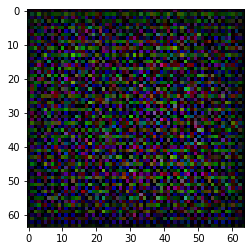

In [ ]:
# check the generator output is of the right type and shape

output = model.generator_forward(generate_random_seed(100))

img = output.detach().permute(0,2,3,1).view(64,64,3).cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')

In [ ]:
%%time 

start_time = time.time()    

discr_costs = []
gener_costs = []
images_from_noise = []
fixed_noise = torch.randn(64, LATENT_DIM, 1, 1, device=device)


epochs = 6
NUM_EPOCHS = epochs

counter = 0;

for epoch in range(epochs):
  model = model.train()
  print ("epoch = ", epoch + 1)


  # train Discriminator and Generator

  for image_data_tensor in celeba_dataset:
    # --------------------------
    # Train Discriminator
    # --------------------------        
    
    optim_discr.zero_grad()
    # get discriminator loss on real images
    discr_pred_real = model.discriminator_forward(image_data_tensor).view(-1)
    real_loss = loss_function(discr_pred_real, torch.cuda.FloatTensor([1.0]))
    #real_loss.backward()
    
    # get discriminator loss on fake images
    fake_images = model.generator_forward(generate_random_seed(100))
    discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
    fake_loss = loss_function(discr_pred_fake, torch.cuda.FloatTensor([0.0]))
    #fake_loss.backward()        

    # combined loss
    discr_loss = 0.5*(real_loss + fake_loss)
    discr_loss.backward()

    optim_discr.step()        

    # --------------------------
    # Train Generator
    # --------------------------      

    optim_gener.zero_grad()        
    
    discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
    gener_loss = loss_function(discr_pred_fake, torch.cuda.FloatTensor([1.0]))
    gener_loss.backward()

    optim_gener.step()

    discr_costs.append(discr_loss.item())
    gener_costs.append(gener_loss.item())
        

    counter+=1;
    ### LOGGING
    if not counter % 1000:
        print ('Epoch: %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                %(epoch+1, epochs, gener_loss, discr_loss))
        
    pass
    
  pass
  ### Save images for evaluation
  with torch.no_grad():
      fake_images = model.generator_forward(fixed_noise).detach().cpu()
      images_from_noise.append(
          vutils.make_grid(fake_images, padding=2, normalize=True))
          
  print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
  
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

epoch =  1
Epoch: 001/006 | Gen/Dis Loss: 2.7579/0.2682
Epoch: 001/006 | Gen/Dis Loss: 2.6650/0.0789
Epoch: 001/006 | Gen/Dis Loss: 2.4673/0.1352
Epoch: 001/006 | Gen/Dis Loss: 2.3179/0.7494
Epoch: 001/006 | Gen/Dis Loss: 3.9630/0.4296
Epoch: 001/006 | Gen/Dis Loss: 2.8702/0.1308
Epoch: 001/006 | Gen/Dis Loss: 2.1533/0.1576
Epoch: 001/006 | Gen/Dis Loss: 3.0421/0.5472
Epoch: 001/006 | Gen/Dis Loss: 2.8000/0.2156
Epoch: 001/006 | Gen/Dis Loss: 3.9414/0.1072
Epoch: 001/006 | Gen/Dis Loss: 3.1586/0.0464
Epoch: 001/006 | Gen/Dis Loss: 2.8110/0.0570
Epoch: 001/006 | Gen/Dis Loss: 4.6705/0.0343
Epoch: 001/006 | Gen/Dis Loss: 2.7685/0.0506
Epoch: 001/006 | Gen/Dis Loss: 2.0283/0.1120
Epoch: 001/006 | Gen/Dis Loss: 1.0800/0.6030
Epoch: 001/006 | Gen/Dis Loss: 2.5802/0.0965
Epoch: 001/006 | Gen/Dis Loss: 4.1561/0.0347
Epoch: 001/006 | Gen/Dis Loss: 2.9002/0.0244
Epoch: 001/006 | Gen/Dis Loss: 1.0543/1.2778
Time elapsed: 6.36 min
epoch =  2
Epoch: 002/006 | Gen/Dis Loss: 6.2176/0.0385
Epoch: 002

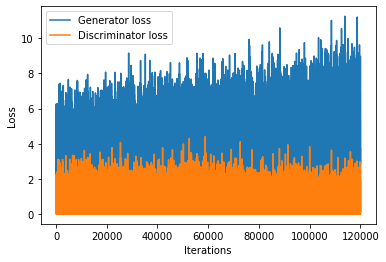

In [ ]:
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), gener_costs, label='Generator loss')
ax1.plot(range(len(discr_costs)), discr_costs, label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()


plt.show()

In [ ]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 5):
    plt.imshow(np.transpose(images_from_noise[i], (1, 2, 0)))
    plt.show()

NameError: ignored

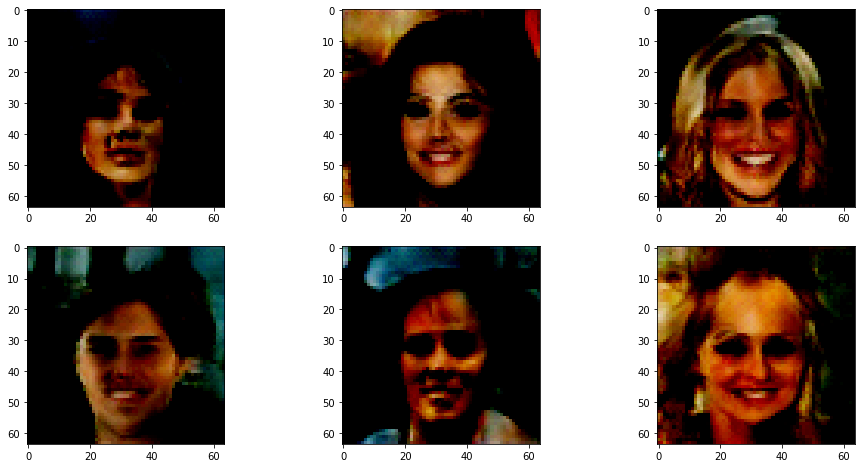

In [ ]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = model.generator_forward(generate_random_seed(100))
        img = output.detach().permute(0,2,3,1).view(64,64,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass